# Install library

In [1]:
import os
import random

import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def set_randvalue(value):
    # Set a seed value
    seed_value= value 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    tf.random.set_seed(seed_value)

set_randvalue(42)

## Dataset preprocessing and EDA

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() # load data
x_train,x_test = x_train.astype('float32')/255.0,x_test.astype('float32')/255.0 # normalization

In [4]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

#### Limit three class preprocessing

In [6]:
# No method on keras to get cifar10 category label name by categoly label?
cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

bird_num = np.where(cifar10_labels=='bird')
deer_num = np.where(cifar10_labels=='deer')
truck_num = np.where(cifar10_labels=='truck')

limit_num = 2500

# get limit label indexes
bird_indexes = [i for i, label in enumerate(y_train) if label == bird_num]
deer_indexes = [i for i, label in enumerate(y_train) if label == deer_num] 
truck_indexes = [i for i, label in enumerate(y_train) if label == truck_num] 
other_indexes = [i for i, label in enumerate(y_train) if label not in [bird_num, deer_num, truck_num]]

# limit
bird_indexes = bird_indexes[:limit_num]
deer_indexes = deer_indexes[:limit_num]
truck_indexes = truck_indexes[:limit_num]
print(f'Bird label num is {len(bird_indexes)}') # 2500
print(f'Deer label num is {len(deer_indexes)}') # 2500
print(f'Truck label num is {len(truck_indexes)}') # 2500
print(f'Other label num is {len(other_indexes)}') # 35000; 5000*7

# merge and sort
merge_indexes = np.concatenate([other_indexes, bird_indexes, deer_indexes, truck_indexes], 0)
merge_indexes.sort()
print(f'Train label num is {len(merge_indexes)}') # 42500

# create three labels removed train data
x_train_removed =  np.zeros((len(merge_indexes), 32, 32, 3))
y_train_removed =  np.zeros(len(merge_indexes))

for i, train_index in enumerate(merge_indexes):
    x_train_removed[i] = x_train[train_index]
    y_train_removed[i] = y_train[train_index]
    
print(x_train_removed.shape)
print(y_train_removed.shape)

Bird label num is 2500
Deer label num is 2500
Truck label num is 2500
Other label num is 35000
Train label num is 42500
(42500, 32, 32, 3)
(42500,)


In [7]:
print(x_train_removed.shape)
print(y_train_removed.shape)
del x_train
del y_train

(42500, 32, 32, 3)
(42500,)


In [8]:
df = pd.DataFrame(y_train_removed.flatten())
print(df.value_counts())
del df

0.0    5000
1.0    5000
3.0    5000
5.0    5000
6.0    5000
7.0    5000
8.0    5000
2.0    2500
4.0    2500
9.0    2500
dtype: int64


(array([5000., 5000., 2500., 5000., 2500., 5000., 5000., 5000., 5000.,
        2500.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

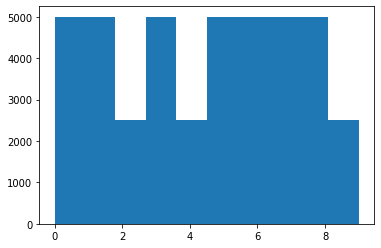

In [9]:
import matplotlib.pyplot as plt

# plot data labels
plt.hist(y_train_removed.flatten())

## AutoEncoder

#### Load AE models weight

In [10]:
# Batch Norm Model
def create_AE01_model(k_size):
    input_img = Input(shape=(32, 32, 3))  # 0
    conv1 = Conv2D(64, (k_size, k_size), padding='same', name="Dense_AE01_1")(input_img) # 1
    conv1 = BatchNormalization(name="BN_AE01_1")(conv1) # 2
    conv1 = Activation('relu', name="Relu_AE01_1")(conv1) # 3
        
    decoded = Conv2D(3, (k_size, k_size), padding='same', name="Dense_AE01_2")(conv1) # 4
    decoded = BatchNormalization(name="BN_AE01_2")(decoded) # 5
    decoded = Activation('relu', name="Relu_AE01_2")(decoded) # 6
    return Model(input_img, decoded)

class AE01():
    def __init__(self, ksize, optimizer):
        self.optimizer = optimizer
        
        self.autoencoder = create_AE01_model(ksize)
        self.encoder = None

    def compile(self, optimizer='adam', loss='binary_crossentropy'):
        self.autoencoder.compile(optimizer=self.optimizer, loss=loss)

    def train(self, x_train=None, x_test=None, epochs=1, batch_size=32, shuffle=True):
        es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
        ae_model_path = '../models/AE/AE01_AE_Best.hdf5'
        cp_cb = ModelCheckpoint(filepath = ae_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        history = self.autoencoder.fit(x_train, x_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             callbacks=[es_cb, cp_cb],
                             validation_data=(x_test, x_test))
        
        self.autoencoder.load_weights(ae_model_path)
        
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        encode_model_path = '../models/AE/AE01_Encoder_Best.hdf5'
        self.encoder.save(encode_model_path)
        return history
    
    def load_weights(self, ae_model_path, encode_model_path):
        self.autoencoder.load_weights(ae_model_path)
        self.encoder = Model(self.autoencoder.input, self.autoencoder.get_layer('Relu_AE01_1').output)
        self.encoder.load_weights(encode_model_path)

In [11]:
ae_ksize = 3
ae_optimizer = 'rmsprop'
stack01 = AE01(ae_ksize, ae_optimizer)
stack01.load_weights('../models/AE/AE01_AE_Best.hdf5', '../models/AE/AE01_Encoder_Best.hdf5')
stack01.encoder.trainable = False
stack01.encoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
Dense_AE01_1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
BN_AE01_1 (BatchNormalizatio (None, 32, 32, 64)        256       
_________________________________________________________________
Relu_AE01_1 (Activation)     (None, 32, 32, 64)        0         
Total params: 2,048
Trainable params: 0
Non-trainable params: 2,048
_________________________________________________________________


## Train

#### Create Model AE to CNN

In [12]:
def create_StackedAE01_CNN01_model(encoder):
    input_img = encoder.input
    output = encoder.layers[-1].output # 32,32,64
    x = Conv2D(64,(3,3),padding = "same",activation= "relu")(output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x) # 16,16,64
    
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding = "same",activation= "relu")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x) # 8,8,128
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    y = Dense(10,activation = "softmax")(x)

    return Model(input_img, y)

#### Train without data augumentation & Class weight

In [18]:
%%time

# train
saveDir = "../models/CNN/"
histories = []
class_weights_arr = [] # for calc class weight 
nb_classes = 10
predicts = np.zeros((10000, 10))

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model01 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model01.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # calculate class weights
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(y_train_),
                                                     y_train_)
    class_weights_arr.append(class_weights)
    class_weights = dict(enumerate(class_weights))

    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_011_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    model01_history = model01.fit(x_train_, y_train_onehot,
                          batch_size=32,
                          epochs=400,
                          verbose=1,
                          validation_data=(x_valid_, y_valid_onehot),
                          callbacks=[es_cb, cp_cb],
                          class_weight=class_weights,
                          shuffle=True)
    
    # inference
    model01.load_weights(chkpt)
    scores = model01.evaluate(x_test, y_test_onehot)
    print(f'Score for fold {fold_no}: {model01.metrics_names[0]} of {scores[0]}; {model01.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model01.predict(x_test)
    predicts += predict
    
    histories.append(model01_history.history)
    fold_no += 1

C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[6. 9. 9. ... 0. 0. 6.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/400
885/886 [============================>.] - ETA: 0s - loss: 1.4861 - accuracy: 0.4726
Epoch 00001: val_loss improved from inf to 1.74187, saving model to ../models/CNN\Model_0011_1_Best.hdf5
886/886 [==============================] - 70s 79ms/step - loss: 1.4860 - accuracy: 0.4726 - val_loss: 1.7419 - val_accuracy: 0.4277
Epoch 2/400
885/886 [============================>.] - ETA: 0s - loss: 1.0941 - accuracy: 0.6200
Epoch 00002: val_loss improved from 1.74187 to 1.24031, saving model to ../models/CNN\Model_0011_1_Best.hdf5
886/886 [==============================] - 70s 79ms/step - loss: 1.0939 - accuracy: 0.6201 - val_loss: 1.2403 - val_accuracy: 0.5759
Epoch 3/400
885/886 [============================>.] - ETA: 0s - loss: 0.9059 - accuracy: 0.6874
Epoch 00003: val_loss improved from 1.24031 to 1.07375, saving model to ../models/CNN\Model_0011_1_Best.hdf5
886/886 [==============================] - 70s 79ms/step - loss: 0.9059 - accuracy: 0.6874 - val_loss: 1.0737 - val_accu

C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[9. 9. 4. ... 6. 1. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/400
885/886 [============================>.] - ETA: 0s - loss: 1.4705 - accuracy: 0.4766
Epoch 00001: val_loss improved from inf to 1.41314, saving model to ../models/CNN\Model_0011_2_Best.hdf5
886/886 [==============================] - 69s 78ms/step - loss: 1.4703 - accuracy: 0.4767 - val_loss: 1.4131 - val_accuracy: 0.5134
Epoch 2/400
885/886 [============================>.] - ETA: 0s - loss: 1.0891 - accuracy: 0.6238
Epoch 00002: val_loss improved from 1.41314 to 1.18230, saving model to ../models/CNN\Model_0011_2_Best.hdf5
886/886 [==============================] - 69s 78ms/step - loss: 1.0891 - accuracy: 0.6238 - val_loss: 1.1823 - val_accuracy: 0.5838
Epoch 3/400
885/886 [============================>.] - ETA: 0s - loss: 0.8918 - accuracy: 0.6893
Epoch 00003: val_loss improved from 1.18230 to 1.01027, saving model to ../models/CNN\Model_0011_2_Best.hdf5
886/886 [==============================] - 69s 78ms/step - loss: 0.8918 - accuracy: 0.6892 - val_loss: 1.0103 - val_accu

C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[6. 4. 1. ... 0. 1. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/400
885/886 [============================>.] - ETA: 0s - loss: 1.4812 - accuracy: 0.4761
Epoch 00001: val_loss improved from inf to 1.47447, saving model to ../models/CNN\Model_0011_3_Best.hdf5
886/886 [==============================] - 69s 77ms/step - loss: 1.4812 - accuracy: 0.4761 - val_loss: 1.4745 - val_accuracy: 0.4912
Epoch 2/400
885/886 [============================>.] - ETA: 0s - loss: 1.1003 - accuracy: 0.6177
Epoch 00002: val_loss improved from 1.47447 to 1.22268, saving model to ../models/CNN\Model_0011_3_Best.hdf5
886/886 [==============================] - 71s 80ms/step - loss: 1.1005 - accuracy: 0.6176 - val_loss: 1.2227 - val_accuracy: 0.5730
Epoch 3/400
885/886 [============================>.] - ETA: 0s - loss: 0.9028 - accuracy: 0.6820
Epoch 00003: val_loss improved from 1.22268 to 0.92061, saving model to ../models/CNN\Model_0011_3_Best.hdf5
886/886 [==============================] - 71s 80ms/step - loss: 0.9027 - accuracy: 0.6819 - val_loss: 0.9206 - val_accu

In [24]:
# print classs weight
ensemble_class_weights_arr = class_weights_arr
for class_weight_ in ensemble_class_weights_arr:
    print(dict(enumerate(class_weight_)))

{0: 0.85007500750075, 1: 0.8498200359928014, 2: 1.7006602641056423, 3: 0.85007500750075, 4: 1.7006602641056423, 5: 0.8498200359928014, 6: 0.85007500750075, 7: 0.8498200359928014, 8: 0.85007500750075, 9: 1.6996400719856029}
{0: 0.85007500750075, 1: 0.85007500750075, 2: 1.6996400719856029, 3: 0.8498200359928014, 4: 1.6996400719856029, 5: 0.85007500750075, 6: 0.85007500750075, 7: 0.85007500750075, 8: 0.85007500750075, 9: 1.6996400719856029}
{0: 0.8498500299940012, 1: 0.8501050105010501, 2: 1.6997000599880023, 3: 0.8501050105010501, 4: 1.6997000599880023, 5: 0.8501050105010501, 6: 0.8498500299940012, 7: 0.8501050105010501, 8: 0.8498500299940012, 9: 1.7007202881152461}


In [23]:
ensemble_histories = histories
ensemble_predicts = predicts
ensemble_predicts_ = ensemble_predicts / n_splits
y_pred = np.argmax(ensemble_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.86      0.92      0.89      1000
           2       0.62      0.74      0.67      1000
           3       0.58      0.71      0.64      1000
           4       0.84      0.59      0.69      1000
           5       0.75      0.71      0.73      1000
           6       0.80      0.82      0.81      1000
           7       0.85      0.83      0.84      1000
           8       0.91      0.85      0.88      1000
           9       0.93      0.79      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



#### Train with data augumentation & Class weight

In [26]:
%%time

# train
saveDir = "../models/CNN/"
histories = []
class_weights_arr = [] # for calc class weight 
nb_classes = 10
predicts = np.zeros((10000, 10))

# cross validation
# Define the K-fold Cross Validator
n_splits = 3
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
fold_no = 1
for train_index, test_index in kfold.split(x_train_removed, y_train_removed):
    # model instance
    model02 = create_StackedAE01_CNN01_model(stack01.encoder)
    adam = Adam() # defalut
    model02.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])

    x_train_ = x_train_removed[train_index]
    y_train_ = y_train_removed[train_index]
    x_valid_ = x_train_removed[test_index]
    y_valid_ = y_train_removed[test_index]

    # calculate class weights
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(y_train_),
                                                     y_train_)
    class_weights_arr.append(class_weights)
    class_weights = dict(enumerate(class_weights))
    
    # one hot encoding
    y_train_onehot = to_categorical(y_train_, nb_classes)
    y_valid_onehot = to_categorical(y_valid_, nb_classes)
    y_test_onehot = to_categorical(y_test, nb_classes)
    
    # callback
    es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    chkpt = saveDir + 'Model_012_' +  str(fold_no) + '_Best.hdf5'
    cp_cb = ModelCheckpoint(filepath = chkpt, \
       monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    
    # create generator
    train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     shear_range=0.2,
    horizontal_flip=True,
#     vertical_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    zoom_range=0.1
#     channel_shift_range=0.2
    )

    batch_size = 32
    train_datagenerator = train_datagen.flow(x_train_, y_train_onehot, batch_size)
    valid_datagenerator = ImageDataGenerator().flow(x_valid_, y_valid_onehot, batch_size)

    model02_history = model02.fit_generator(train_datagenerator,
                                  steps_per_epoch=int(len(x_train_)//batch_size),
                                  epochs=400,
                                  validation_data=valid_datagenerator,
                                  validation_steps=int(len(x_valid_)//batch_size),
                                  verbose=1,
                                  shuffle=True,
                                  class_weight=class_weights,
                                  callbacks=[es_cb, cp_cb])

    # inference
    model02.load_weights(chkpt)
    scores = model02.evaluate(x_test, y_test_onehot)
    print(f'Score for fold {fold_no}: {model02.metrics_names[0]} of {scores[0]}; {model02.metrics_names[1]} of {scores[1]*100}%')
    
    predict = model02.predict(x_test)
    predicts += predict
    
    histories.append(model02_history.history)
    fold_no += 1

C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[6. 9. 9. ... 0. 6. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/400
885/885 [==============================] - ETA: 0s - loss: 1.5395 - accuracy: 0.4619 ETA: 5s - l
Epoch 00001: val_loss improved from inf to 1.54529, saving model to ../models/CNN\Model_0012_1_Best.hdf5
885/885 [==============================] - 86s 97ms/step - loss: 1.5395 - accuracy: 0.4619 - val_loss: 1.5453 - val_accuracy: 0.4864
Epoch 2/400
885/885 [==============================] - ETA: 0s - loss: 1.1773 - accuracy: 0.5906
Epoch 00002: val_loss improved from 1.54529 to 1.08471, saving model to ../models/CNN\Model_0012_1_Best.hdf5
885/885 [==============================] - 82s 93ms/step - loss: 1.1773 - accuracy: 0.5906 - val_loss: 1.0847 - val_accuracy: 0.6174
Epoch 3/400
885/885 [==============================] - ETA: 0s - loss: 1.0015 - accuracy: 0.6509
Epoch 00003: val_loss did not improve from 1.08471
885/885 [==============================] - 82s 92ms/step - loss: 1.0015 - accuracy: 0.6509 - val_loss: 1.1786 - val_accuracy: 0.6010
Epoch 4/400
885/885 [============

C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[6. 9. 4. ... 0. 6. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/400
885/885 [==============================] - ETA: 0s - loss: 1.5459 - accuracy: 0.4550
Epoch 00001: val_loss improved from inf to 1.43595, saving model to ../models/CNN\Model_0012_2_Best.hdf5
885/885 [==============================] - 72s 81ms/step - loss: 1.5459 - accuracy: 0.4550 - val_loss: 1.4360 - val_accuracy: 0.5185
Epoch 2/400
885/885 [==============================] - ETA: 0s - loss: 1.1895 - accuracy: 0.5848
Epoch 00002: val_loss did not improve from 1.43595
885/885 [==============================] - 71s 80ms/step - loss: 1.1895 - accuracy: 0.5848 - val_loss: 1.6055 - val_accuracy: 0.5050
Epoch 3/400
885/885 [==============================] - ETA: 0s - loss: 1.0125 - accuracy: 0.6485
Epoch 00003: val_loss improved from 1.43595 to 1.09172, saving model to ../models/CNN\Model_0012_2_Best.hdf5
885/885 [==============================] - 70s 80ms/step - loss: 1.0125 - accuracy: 0.6485 - val_loss: 1.0917 - val_accuracy: 0.6326
Epoch 4/400
885/885 [========================

C:\Users\koki inoue\anaconda3\envs\tf2.3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.], y=[9. 1. 2. ... 1. 1. 1.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Epoch 1/400
885/885 [==============================] - ETA: 0s - loss: 1.5345 - accuracy: 0.4577
Epoch 00001: val_loss improved from inf to 1.42552, saving model to ../models/CNN\Model_0012_3_Best.hdf5
885/885 [==============================] - 72s 82ms/step - loss: 1.5345 - accuracy: 0.4577 - val_loss: 1.4255 - val_accuracy: 0.4982
Epoch 2/400
885/885 [==============================] - ETA: 0s - loss: 1.1779 - accuracy: 0.5887
Epoch 00002: val_loss did not improve from 1.42552
885/885 [==============================] - 71s 80ms/step - loss: 1.1779 - accuracy: 0.5887 - val_loss: 1.5431 - val_accuracy: 0.4834
Epoch 3/400
885/885 [==============================] - ETA: 0s - loss: 0.9975 - accuracy: 0.6549
Epoch 00003: val_loss improved from 1.42552 to 1.20448, saving model to ../models/CNN\Model_0012_3_Best.hdf5
885/885 [==============================] - 71s 80ms/step - loss: 0.9975 - accuracy: 0.6549 - val_loss: 1.2045 - val_accuracy: 0.6094
Epoch 4/400
885/885 [========================

In [27]:
# print classs weight
ensemble_dataaug_class_weights_arr = class_weights_arr
for class_weight_ in ensemble_dataaug_class_weights_arr:
    print(dict(enumerate(class_weight_)))

{0: 0.85007500750075, 1: 0.8498200359928014, 2: 1.7006602641056423, 3: 0.85007500750075, 4: 1.7006602641056423, 5: 0.8498200359928014, 6: 0.85007500750075, 7: 0.8498200359928014, 8: 0.85007500750075, 9: 1.6996400719856029}
{0: 0.85007500750075, 1: 0.85007500750075, 2: 1.6996400719856029, 3: 0.8498200359928014, 4: 1.6996400719856029, 5: 0.85007500750075, 6: 0.85007500750075, 7: 0.85007500750075, 8: 0.85007500750075, 9: 1.6996400719856029}
{0: 0.8498500299940012, 1: 0.8501050105010501, 2: 1.6997000599880023, 3: 0.8501050105010501, 4: 1.6997000599880023, 5: 0.8501050105010501, 6: 0.8498500299940012, 7: 0.8501050105010501, 8: 0.8498500299940012, 9: 1.7007202881152461}


In [28]:
ensemble_dataaug_histories = histories
ensemble_dataaug_predicts = predicts
ensemble_dataaug_predicts_ = ensemble_dataaug_predicts / n_splits
y_pred = np.argmax(ensemble_dataaug_predicts_, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1000
           1       0.87      0.94      0.91      1000
           2       0.81      0.64      0.71      1000
           3       0.66      0.67      0.66      1000
           4       0.86      0.67      0.76      1000
           5       0.80      0.71      0.75      1000
           6       0.74      0.91      0.82      1000
           7       0.78      0.90      0.84      1000
           8       0.85      0.93      0.89      1000
           9       0.90      0.86      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000

